# Deep Generative Models — Companion Notebook

This notebook follows the lecture slides step by step with **analytical derivations**, **visualisations**, and **fully-worked computational examples**.

**Sections**
1. Neural Networks as Distribution Parametrisers
2. Directed Graphical Models — plate notation & the generative story
3. Maximum Likelihood Estimation & SGD
4. The Evidence Lower Bound (ELBO)
5. Variational Autoencoder (VAE) — toy 2D data + bearing health monitoring
6. Discrete Variational Encoder — score function estimator & baselines

---

In [1]:
# ── Standard imports ──────────────────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal, Bernoulli, Categorical, kl_divergence
from scipy.fft import rfft, rfftfreq
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from torch.utils.data import TensorDataset, DataLoader

plt.rcParams.update({'figure.dpi': 120, 'font.size': 11})
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


---
## Section 1 — Neural Networks as Distribution Parametrisers

### Slide concept
Instead of choosing distribution parameters by hand, we let a neural network **predict** them from observed side information $\phi$:
$$X|\phi \sim \mathcal{N}(\mu_\theta(\phi),\, \sigma_\theta(\phi)^2)$$

### Analytical example
Suppose the true data-generating process is
$$y = \sin(2\pi x) + \epsilon, \quad \epsilon\sim\mathcal{N}(0, 0.1^2)$$
We fit a neural network that outputs $(\mu_\theta(x), \log\sigma_\theta(x))$.

# Neural Network that Predicts a Gaussian Distribution (Mean + Noise)

## 1) What this code is doing (high-level overview)

This script performs **probabilistic regression** on 1D data.  
Instead of predicting a single output value $\hat{y}$ for each input $x$, the neural network predicts a **Gaussian distribution** for $y\mid x$:

$
y \mid x \sim \mathcal{N}\big(\mu_\theta(x),\ \sigma_\theta(x)^2\big)
$

So the network learns two functions:
- **$\mu_\theta(x)$**: the **mean** prediction (the regression curve)
- **$\sigma_\theta(x)$**: the **standard deviation** (the noise/uncertainty of observations around the mean)

This setup is commonly used to model **heteroscedastic regression** (input-dependent noise), although in this specific synthetic dataset the true noise is constant.

---

## 2) Data generating process (the "ground truth")

We generate points $x \in [0,1]$ and noisy observations:

$
y = \sin(2\pi x) + \epsilon,\quad \epsilon \sim \mathcal{N}(0,\ 0.1^2)
$

So the ground truth is:
- True mean: $\mu^*(x)=\sin(2\pi x)$
- True noise level: $\sigma^*(x)=0.1$ (constant)

This makes it possible to **verify** whether the network learned the correct mean and noise.

---

## 3) Model: a neural network with two heads

The network has:
- A shared feature extractor (MLP)
- A head for $\mu_\theta(x)$
- A head for $\log\sigma_\theta(x)$

We predict **log-sigma** because sigma must be positive:
$
\sigma = \exp(\log\sigma)
$

We also clamp $\log\sigma$ to avoid numerical issues.

---

## 4) Training objective: Gaussian Negative Log Likelihood (NLL)

Training minimizes the Gaussian negative log-likelihood:

$
-\log p(y\mid x) =
\log\sigma_\theta(x) + \frac{1}{2}\left(\frac{y-\mu_\theta(x)}{\sigma_\theta(x)}\right)^2
+ \frac{1}{2}\log(2\pi)
$

**Important note:**  
Many implementations drop the constant $\tfrac{1}{2}\log(2\pi)$ because it does not affect gradients.  
If you drop it, the NLL can easily become **negative**, which is normal.

---


Final NLL: -1.8888


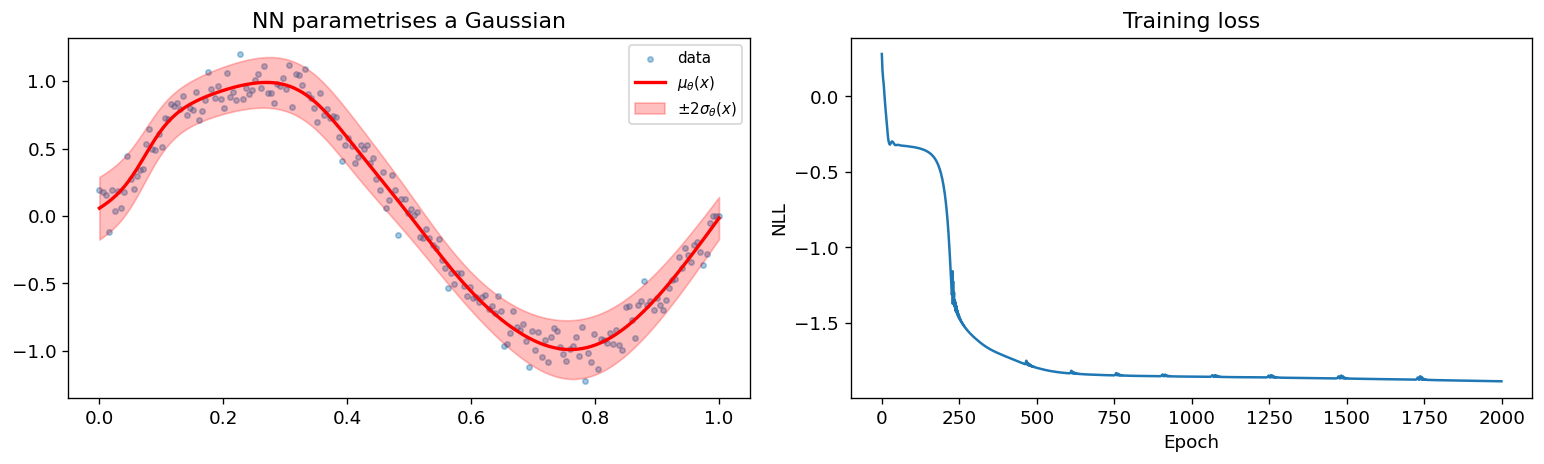

In [2]:
# ── 1A. Data generation ───────────────────────────────────────────
N = 200
x_data = torch.linspace(0, 1, N).unsqueeze(1)
y_data = torch.sin(2 * np.pi * x_data) + 0.1 * torch.randn(N, 1)

# ── 1B. Model: NN that parametrises a Gaussian ────────────────────
class GaussianNN(nn.Module):
    """Outputs mu and log_sigma for a Gaussian likelihood."""
    def __init__(self, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh()
        )
        self.mu_head    = nn.Linear(hidden, 1)
        self.log_sigma_head = nn.Linear(hidden, 1)

    def forward(self, x):
        h = self.net(x)
        mu        = self.mu_head(h)
        log_sigma = self.log_sigma_head(h).clamp(-6, 2)   # numerical stability
        return mu, log_sigma

model = GaussianNN()
opt   = optim.Adam(model.parameters(), lr=1e-3)

# ── 1C. Training via NLL ──────────────────────────────────────────
losses = []
for epoch in range(2000):
    mu, log_sigma = model(x_data)
    sigma = log_sigma.exp()
    # Negative log-likelihood of a Gaussian
    nll = (log_sigma + 0.5 * ((y_data - mu) / sigma)**2).mean()
    opt.zero_grad(); nll.backward(); opt.step()
    losses.append(nll.item())

print(f'Final NLL: {losses[-1]:.4f}')

# ── 1D. Visualisation ─────────────────────────────────────────────
x_test = torch.linspace(0, 1, 300).unsqueeze(1)
with torch.no_grad():
    mu_test, log_sigma_test = model(x_test)
    sigma_test = log_sigma_test.exp()

mu_np    = mu_test.squeeze().numpy()
sigma_np = sigma_test.squeeze().numpy()
x_np     = x_test.squeeze().numpy()

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

axes[0].scatter(x_data.numpy(), y_data.numpy(), s=10, alpha=0.4, label='data')
axes[0].plot(x_np, mu_np, 'r-', lw=2, label=r'$\mu_\theta(x)$')
axes[0].fill_between(x_np, mu_np - 2*sigma_np, mu_np + 2*sigma_np,
                     alpha=0.25, color='red', label=r'$\pm 2\sigma_\theta(x)$')
axes[0].set_title('NN parametrises a Gaussian')
axes[0].legend(fontsize=9)

axes[1].plot(losses)
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('NLL')
axes[1].set_title('Training loss')

plt.tight_layout()
plt.savefig('sec1_gaussian_nn.png', bbox_inches='tight')
plt.show()

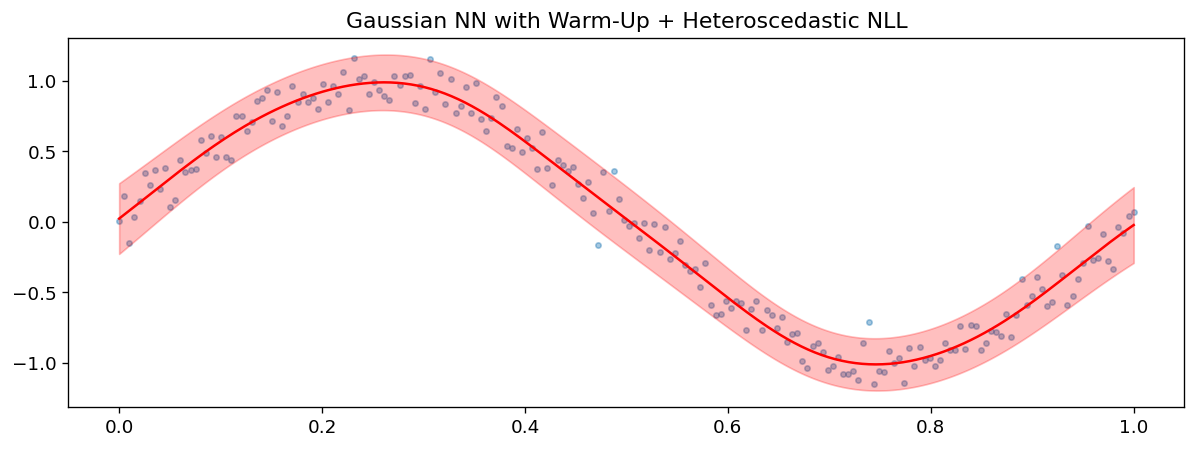

In [3]:
# ───────────────────────────────────────────────────────────────
# 0. Data
# ───────────────────────────────────────────────────────────────
N = 200
x_data = torch.linspace(0, 1, N).unsqueeze(1)
y_data = torch.sin(2*np.pi*x_data) + 0.1*torch.randn(N, 1)

# ───────────────────────────────────────────────────────────────
# 1. Model Definition
# ───────────────────────────────────────────────────────────────
class GaussianNN(nn.Module):
    """NN with dual head: mu(x) and log_sigma(x)."""
    def __init__(self, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh()
        )
        self.mu_head         = nn.Linear(hidden, 1)
        self.log_sigma_head  = nn.Linear(hidden, 1)

    def forward(self, x):
        h = self.net(x)
        mu  = self.mu_head(h)
        # softplus is safer than clamp/exp (never negative, no saturation)
        log_sigma = self.log_sigma_head(h)
        return mu, log_sigma


model = GaussianNN()
opt   = torch.optim.Adam(model.parameters(), lr=1e-3)

# Freeze variance head during warm‑up
for p in model.log_sigma_head.parameters():
    p.requires_grad = False


# ───────────────────────────────────────────────────────────────
# 2. Phase 1 — Mean Warm‑up
# ───────────────────────────────────────────────────────────────
T_warm = 500
sigma_fixed = 0.2   # arbitrary fixed variance

for epoch in range(T_warm):
    mu, _ = model(x_data)
    loss = ((y_data - mu)**2 / (2 * sigma_fixed**2)).mean()

    opt.zero_grad()
    loss.backward()
    opt.step()


# ───────────────────────────────────────────────────────────────
# 3. Phase 2 — Joint Mean + Variance Training (Heteroscedastic NLL)
# ───────────────────────────────────────────────────────────────
# Unfreeze variance parameters
for p in model.log_sigma_head.parameters():
    p.requires_grad = True

lambda_reg = 1e-4          # mild variance regularizer
T_total = 2000

for epoch in range(T_warm, T_total):
    mu, log_sigma = model(x_data)
    sigma = torch.exp(log_sigma)

    # Heteroscedastic Gaussian NLL
    nll = (log_sigma + 0.5*((y_data - mu)/sigma)**2).mean()

    # Optional variance regularizer
    reg = lambda_reg * (log_sigma**2).mean()

    loss = nll + reg

    opt.zero_grad()
    loss.backward()
    opt.step()


# ───────────────────────────────────────────────────────────────
# 4. Visualization (unchanged)
# ───────────────────────────────────────────────────────────────
x_test = torch.linspace(0, 1, 300).unsqueeze(1)
with torch.no_grad():
    mu_test, log_sigma_test = model(x_test)
    sigma_test = torch.exp(log_sigma_test)

plt.figure(figsize=(12,4))
plt.scatter(x_data, y_data, s=10, alpha=0.4)
plt.plot(x_test, mu_test, 'r-')
plt.fill_between(
    x_test.squeeze(),
    (mu_test - 2*sigma_test).squeeze(),
    (mu_test + 2*sigma_test).squeeze(),
    alpha=0.25, color='red'
)
plt.title("Gaussian NN with Warm‑Up + Heteroscedastic NLL")
plt.show()